# Exercise - VaR

## Data

This problem uses `weekly` return data from `data/spx_returns_weekly.xlsx`.

Choose any `4` stocks to evaluate below.

For example, 
* `AAPL`
* `META`
* `NVDA`
* `TSLA`

# 1 Diversification

## 1.1

Using the full sample, calculate for each series the (unconditional) 
* volatility
* empirical VaR (.05)
* empirical CVaR (.05)

Recall that by **empirical** we refer to the direct quantile estimation. (For example, using `.quantile()` in pandas.

## 1.2
Form an equally-weighted portfolio of the investments.

Calculate the statistics of `1.1` for this portfolio, and compare the results to the individual return statistics. What do you find? What is driving this result?

## 1.3
Re-calculate `1.2`, but this time drop your most volatile asset, and replace the portion it was getting with 0. (You could imagine we're replacing the most volatile asset with a negligibly small risk-free rate.)

In comparing the answer here to 1.2, how much risk is your most volatile asset adding to the portfolio? Is this in line with the amount of risk we measured in the stand-alone risk-assessment of `1.1`?

***

# 2. Dynamic Measures

## 2.1 

Let's measure the **conditional** statistics of the equally-weighted portfolio of `1.2`, as of the end of the sample.

#### Volatility
For each security, calculate the **rolling** volatility series, $\sigma_t$, with a window of $m=26$.

The value at $\sigma_t$ in the notes denotes the estimate using data through time $t-1$, and thus (potentially) predicting the volatility at $\sigma_{t}$. 

#### Mean
Suppose we can approximate that the daily mean return is zero.

#### VaR
Calculate the **normal VaR** and **normal CVaR** for $q=.05$ and $\tau=1$ as of the end of the sample.Use the approximation, $\texttt{z}_{.05} = -1.65$.

#### Notation Note
In this setup, we are using a forecasted volatility, $\sigma_t$ to estimate the VaR return we would have estimated at the end of $t-1$ in prediction of time $t$.

#### Conclude and Compare
Report
* volatility (annualized).
* normal VaR (.05)
* normal CVaR (.05)

How do these compare to the answers in `1.2`?

## 2.2

Backtest the VaR using the **hit test**. Namely, check how many times the realized return at $t$ was smaller than the VaR return calculated using $\sigma_t$, (where again remember the notation in the notes uses $\sigma_t$ as a vol based on data through $t-1$.)

Report the percentage of "hits" using both the 
* expanding volatility
* rolling volatility

***

# <span style="color:red">Solutions</span>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from portfolio import *
from risk import *

## <span style="color:red">Solution 1</span>

In [ ]:
LOADFILE = '../data/spx_returns_weekly.xlsx'
TICKS = [
    'AAPL',
    'META',
    'NVDA',
    'TSLA'
    ]
FREQ = 52
WINDOW = 26

QUANTILE = .05
mu = 0

SHEET = 's&p500 rets'
rets = pd.read_excel(LOADFILE,sheet_name=SHEET).set_index('date')
rets = rets[TICKS]
rets.dropna(inplace=True)

In [ ]:
ANNUALIZE = np.sqrt(252)

rtab = rets.copy()
TICK_MAX_VOL = rets.std().idxmax()

rtab['portfolio'] = rtab.mean(axis=1)
rtab[f'portfolio-ex {TICK_MAX_VOL}'] = rtab.drop(columns=[TICK_MAX_VOL]).sum(axis=1)/4
rtab[f'stand-alone {TICK_MAX_VOL}'] = rtab[[TICK_MAX_VOL]]/4

risk0 = pd.DataFrame(index=['vol'],columns=rtab.columns,dtype=float)
risk0.loc['vol'] = rtab.std() * ANNUALIZE
risk0.loc[f'VaR {QUANTILE}'] = rtab.quantile(QUANTILE)
risk0.loc[f'CVaR {QUANTILE}'] = rtab[rtab<rtab.quantile(QUANTILE)].mean()

risk0.style.format('{:.2%}')

The explanation for this diversifiction is easiest seen for the case of volatility, which due to imperfect correlations, is strictly subadditive.
* The relatively low correlations of the chosen futures contracts means the diversification effect is substantial.
* Though VaR is not subadditive in general, it is in many specific cases, including here.

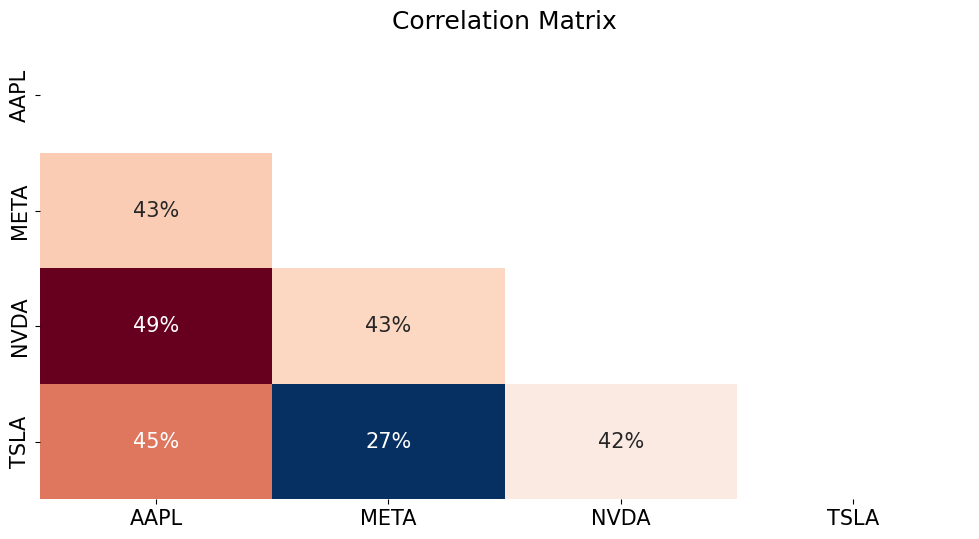

In [ ]:
from matplotlib.colors import TwoSlopeNorm

corr_matrix = rets.corr()

# Set upper triangle and diagonal to NaN
mask = np.triu(np.ones_like(corr_matrix), k=0)  # Using triu to get upper triangle including diagonal
corr_matrix[mask.astype(bool)] = np.nan

center = corr_matrix.mean().mean()
vmin = corr_matrix.min().min()
vmax = corr_matrix.max().max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
sns.heatmap(corr_matrix, annot=True, fmt='.0%', norm=norm, cmap='RdBu_r', cbar=False)
plt.title('Correlation Matrix')
plt.show()

***

## <span style="color:red">Solution 2</span>

In [ ]:
method = 'rolling'

rets['portfolio'] = rets.mean(axis=1)

if method == 'rolling':
    sigma = rets.rolling(WINDOW).std()
elif method == 'expanding':
    sigma = rets.expanding(WINDOW).std()

sigma.plot();

In [ ]:
from scipy.stats import norm
zscore = norm.ppf(QUANTILE)
phi = norm.pdf(zscore)

VaRret = mu + zscore * sigma
CVaRret = mu - phi / QUANTILE * sigma

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(14,8))
for i,tick in enumerate(TICKS):
    VaRret[tick].plot(ax=ax[i%2,int(np.floor(i/2))],title=f'{tick}')
    CVaRret[tick].plot(ax=ax[i%2,int(np.floor(i/2))],title=f'{tick}')
    
plt.tight_layout()

In [ ]:
tabcomp = risk0.iloc[1,:-2].to_frame('unconditional').join(VaRret.iloc[-1,:].to_frame('conditional'))
tabcvar = risk0.iloc[2,:-2].to_frame('unconditional').join(CVaRret.iloc[-1,:].to_frame('conditional'))
tabcomp = pd.concat([tabcomp,tabcvar],keys=['VaR','CVaR'],axis=1)
tabcomp.style.format('{:.1%}')

In [ ]:
hits = rets < VaRret.shift()

(hits.sum()/hits.shape[0]).to_frame('Hit Ratio').style.format('{:.2%}')